# Torus links and neural networks

We propose to investigate how complex a neural network needs to be in order to accurately distinguish the components of increasingly tangled links in ambient three-dimensional space. More precisely, we use simulated data to measure the size and number of layers a neural network needs to have to successfully separate the components of torus links. If a reader needs a quick exposition about torus knots and links, the wikipedia page wikipedia.org/wiki/Torus_knot provides a fast account. Key facts are: 
- a torus link is a link in Euclidean $3$-space whose strands lie on the surface of the standardly embedded torus,
- the $(p, q)$-torus link has $n = gcd(p, q)$ components, each of which is a $(p', q')$-torus knot where $p' = p/n$, $q' = q/n$, 
- the $(p, q)$-torus knot for coprime $p, q$ winds around the torus $p$ times in the longitude direction and $q$ times around the meridian direction. 

At each step of our experiment, we shall fix integers $p$ and $q$ with $gcd(p, q) = n$ and train neural networks to tell apart the $n$ strands of the $(p, q)$-torus link. As $p$ and $q$ increase, the torus link of type $(p, q)$ becomes increasingly tangled, in the sense that its crossing number, linking number and many other invariants increase. The cases where $n = gcd(p, q)$ is low are of prime interest, since few strands are often enough to get very complicated links. 

## Generating the simulated data

We begin with Python functions generating points that lie on the $n$ strands of a $(p, q)$-torus link, $gcd(p, q) = n$. Thankfully, there are easy parameterizations for these embeddings. (This actually motivated the choice of torus links over other infinite families. In general, finding parameterizations or algebraic equations for a link is a notoriously hard problem.) If $p$ and $q$ are coprime, the one and only strand of the $(p, q)$-torus knot is parameterized by
$$
x(t) = (\cos(qt) + 2)\cos(pt), 
$$
$$
y(t) = (\cos(qt) + 2)\sin(pt), 
$$
$$
z(t) = -\sin(qt),
$$
where $t \in [0, 2\pi]$. When $n = gcd(p, q)$ is greater than one, we can use the parameterization above with $p' = p/n$ and $q' = q/n$ to get one component of the $(p, q)$-torus link. We then rely on the following fact: the other components are obtained by applying rotations of angles $2\pi k/qn$, $0 < k < n$ along the $z$-axis to the first component. The proof of this last assertion follows from further properties of torus knots and links. It can be derived from, e.g, the connection between torus links and the algebraic equations $w_1^p + w_2^q = 0$ in $\mathbb{C}^2$. From now on, we speak of the zeroth, first, ..., $(n-1)$-st component of a link, instead of the first, second, ... etc. to match Python's enumerating conventions. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
%matplotlib widget 
#This last line requires the jupyter-matplotlib extension. pip install ipympl

In [2]:
def x(p, q, t, phase_shift):
    return (np.cos(q*t) + 2)*np.cos(p*t + phase_shift) #These two phase shifts will implement the rotations advertized above.

def y(p, q, t, phase_shift):
    return (np.cos(q*t) + 2)*np.sin(p*t + phase_shift) #These two phase shifts will implement the rotations advertized above.

def z(q, t):
    return -np.sin(q*t)

def torusLink(p, q, t, phase_shift):
    return [x(p, q, t, phase_shift), y(p, q, t, phase_shift), z(q, t)]

In [3]:
#Implements the generation strategy outlined above. 
def simulateData(p, q, N): 
    n = np.gcd(p, q)
    p_prime = int(p/n)
    q_prime = int(q/n)
    features = [torusLink(p_prime, q_prime, t, 0) for t in np.linspace(0, 2*np.pi, num = int(N/n), endpoint = False)]
    responses = np.zeros(int(N/n))
    for k in range(1, n):
        features = np.concatenate((features, [torusLink(p_prime, q_prime, t, 2*np.pi*k/(q_prime*n)) for t in np.linspace(0, 2*np.pi, num = int(N/n), endpoint = False)]))
        responses = np.concatenate((responses, k*np.ones(int(N/n))))
    return features, responses

We are ready to generate data: we do so and plot it. 

In [4]:
p, q = 18, 4
n = int(np.gcd(p, q))
N = 1000
N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
torusLinkFeatures, torusLinksResponses = simulateData(p, q, N)

In [5]:
#A function to plot at most twenty colored collections of points in three dimensions
def threeDimPlot(collections):
    colors = matplotlib.cm.tab10(range(10)) #Provides a collection of twenty colors
    ax = plt.figure().add_subplot(projection = '3d')
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    for (collection, color) in zip(collections, colors): 
        ax.scatter(collection[0], collection[1], collection[2], color = color)
    return ax

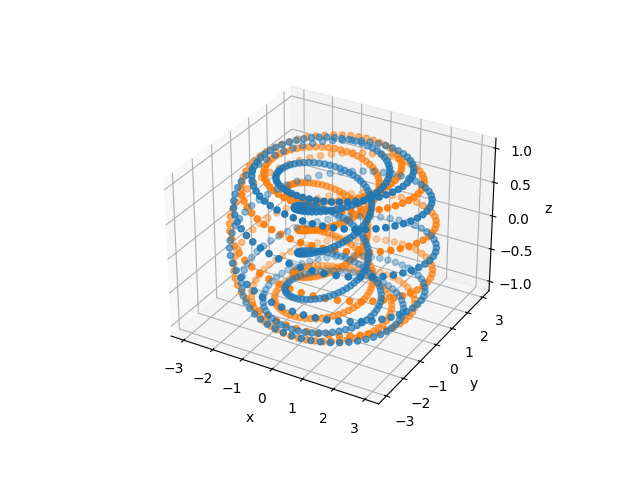

In [6]:
collections = []
for i in range(n): #We retrieve the points in "features" component by component
    x_ = [torusLinkFeatures[k][0] for k in range(i*int(N/n), (i+1)*int(N/n))]
    y_ = [torusLinkFeatures[k][1] for k in range(i*int(N/n), (i+1)*int(N/n))]
    z_ = [torusLinkFeatures[k][2] for k in range(i*int(N/n), (i+1)*int(N/n))]
    collections.append([x_, y_, z_])

ax = threeDimPlot(collections)
plt.show()

In [7]:
plt.close() #Frees the memory occupied by the figure. 

## Training neural networks

We use `torch` to train neural networks. The third cell import wrapper and helper functions from the `ISLP` package. These are not part of `torch`, but are provided by the authors of the ISLP book (https://www.statlearning.com/) to ease the syntax of certain `torch` code snippets in simple cases. 

In [8]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchinfo import summary
from pytorch_lightning.callbacks import EarlyStopping

In [9]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [10]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

### Arranging the data into a `DataModule`

We transform our data into `tensors`, the standard datatype accessible to `torch`. Note that `torch` typically works with 32-bit (= single precision) floating point numbers. We therefore convert the $x$, $y$ and $z$ coordinates of our data to `np.float32` before forming the tensor. On the other hand, the reponse, in the case of a classification problem with more than two possible response, needs to be converted into a 64-bit (long) integer (to use `torch`´s non-binary cross-entropy loss function). The features and responses tensors are then arranged into a `Dataset` using `TensorDataset()`. Because the general training setup in `pytorch_lightning` involves training, validation and test data, we carry this task out three times. Our data is simulated, so this is virtually free. 

In [11]:
p, q = 6, 2
n = int(np.gcd(p, q))
N = 10000
N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
M = n*int(N/(10*n)) #A smaller size for validation and test

features_tmp, responses_tmp = simulateData(p, q, N)
torusLinkFeatures_train_t = torch.tensor(features_tmp.astype(np.float32))
if n == 2:
    torusLinkResponses_train_t = torch.tensor(responses_tmp.astype(np.float32))
else: 
    torusLinkResponses_train_t = torch.tensor(responses_tmp.astype(np.int64))
torusLinkData_train = TensorDataset(torusLinkFeatures_train_t, torusLinkResponses_train_t)

features_tmp, responses_tmp = simulateData(p, q, M)
torusLinkFeatures_val_t = torch.tensor(features_tmp.astype(np.float32))
if n == 2:
    torusLinkResponses_val_t = torch.tensor(responses_tmp.astype(np.float32))
else: 
    torusLinkResponses_val_t = torch.tensor(responses_tmp.astype(np.int64))
torusLinkData_val = TensorDataset(torusLinkFeatures_val_t, torusLinkResponses_val_t)

features_tmp, responses_tmp = simulateData(p, q, M)
torusLinkFeatures_test_t = torch.tensor(features_tmp.astype(np.float32))
if n == 2:
    torusLinkResponses_test_t = torch.tensor(responses_tmp.astype(np.float32))
else:
    torusLinkResponses_test_t = torch.tensor(responses_tmp.astype(np.int64))
torusLinkData_test = TensorDataset(torusLinkFeatures_test_t, torusLinkResponses_test_t)

Each dataset is passed to a `DataLoader()`, which ultimately passes data into the network. The helper function `SimpleDataModule()` from `ISLP` makes this easy. One of its arguments is `num_workers`, which indicates how many processes will be used for the loading of the data. The `torch` package will inspect the process running and determine a maximum number of workers. (This depends on the computing hardware and the number of cores available.) The `ISLP` package contains the function `rec_num_workers()` to compute this. 

In [12]:
max_num_workers = rec_num_workers()
max_num_workers

8

In [13]:
torusLink_dm = SimpleDataModule(torusLinkData_train,
                                  torusLinkData_test,
                                  batch_size = 32,
                                  num_workers = max_num_workers,
                                  validation = torusLinkData_val)

### Specifying the network

We move on to the neural network itself. We define a sub-class `TorusLinkModel` of `torch`'s generic `nn.Module` and specify the architecture of the neural network we want to use. In our situation it is fairly straitghtforward, consisting of linear and ReLU activation layers only. The `layer_sizes` array in the `__init__` method summaries the whole shape of the network: its size indicates the desired number of hidden combined linear-ReLU layers, and the $i$-th value indicates the size of the $i$-th layer. 

In [14]:
class BuildingBlock(nn.Module):
    
    def __init__(self, in_size, out_size): 
        super(BuildingBlock, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.ReLU(),
            nn.Linear(in_size, out_size))

    def forward(self, x):
        x = self.flatten(x)
        return self.sequential(x)

In [15]:
class TorusLinkModel(nn.Module):
    
    def __init__(self, layer_sizes, input_size, output_size): 
        super(TorusLinkModel, self).__init__()
        self.flatten = nn.Flatten()
        if output_size == 2:
            self.output_size_ = 1
        if output_size > 2:
            self.output_size_ = output_size
            
        self.first_maps = nn.Sequential(nn.Linear(input_size, layer_sizes[0]))
        if len(layer_sizes) > 1:
            self.middle_maps = nn.Sequential(*[BuildingBlock(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)])
        else:
            self.middle_maps = nn.Sequential()
        self.last_maps = nn.Sequential(nn.ReLU(), nn.Linear(layer_sizes[-1], self.output_size_))

    def forward(self, x):
        x = self.first_maps(x)
        x = self.middle_maps(x)
        x = self.last_maps(x)
        if self.output_size_ == 1:            
            return torch.flatten(x)
        else:            
            return x

The package `torchinfo` provides a `summary()` function that neatly displays the architecture. We specify the size of the input and see the size of each tensor as it passes through the layers of the network. 

In [22]:
layer_sizes = [9, 9, 9]
torusLink_model = TorusLinkModel(layer_sizes, 3, n)

In [23]:
summary(torusLink_model, 
        input_size = [N, 3],
        col_names = ['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorusLinkModel                           [10000, 3]                [10000]                   --
├─Sequential: 1-1                        [10000, 3]                [10000, 9]                --
│    └─Linear: 2-1                       [10000, 3]                [10000, 9]                36
├─Sequential: 1-2                        [10000, 9]                [10000, 9]                --
│    └─BuildingBlock: 2-2                [10000, 9]                [10000, 9]                --
│    │    └─Flatten: 3-1                 [10000, 9]                [10000, 9]                --
│    │    └─Sequential: 3-2              [10000, 9]                [10000, 9]                90
│    └─BuildingBlock: 2-3                [10000, 9]                [10000, 9]                --
│    │    └─Flatten: 3-3                 [10000, 9]                [10000, 9]                --
│    │    └─Sequential: 3-4        

We summon an instance of TorusLinkModel and build a `Module` with it. We again use a helper function from `ISLP`: `SimpleModule()`. By using the `SimpleModule.classification()` method,  we indicate that we will the cross-entropy loss function. We supply it with the number of classes in the problem. If we were to specify a non-default learning rate (the default one is $0.01$), or other specific instructions for the upcoming stochastic gradient descent, this would be the place to do it (using a `torch optimizer`). 

In [24]:
if n == 2:
    torusLink_module = SimpleModule.binary_classification(torusLink_model)
elif n > 2:
    torusLink_module = SimpleModule.classification(torusLink_model, num_classes = n)

### Setting a logger

We log our results via `CSVLogger()`, which stores the results in a CSV file within a directory `logs/torusLink`. After the fitting is complete, this allows us to easily load the results as a `pd.DataFrame()` and visualize them. 

In [25]:
torusLink_logger = CSVLogger('logs', name = 'torusLink')

### Training the model

Finally we are ready to train our model and log the results. We use the `Trainer()` object from `pytorch_lightning` to do this work. The argument `datamodule = torusLink_dm` tells the trainer how training/validation/test logs are produced, while the first argument `torusLink_module` specifies the network architecture as well as the training/validation/test steps. The `callbacks` argument allows for several tasks to be carried out at various points while training a model. The `ErrorTracker()` callback will enable the computation of the validation accuracy while training and, finally, of test accuracy. Our goal is to measure the how complex neural networks need to be in order to succeed at certain tasks. In particular, we are not interested in the trained models themselves, and do not want to train our networks more than needed. Thus we include an `EarlyStopping` callback to our `Trainer` that interrupts training if at some point during the fitting, the validation accuracy has not been improving by at least $1\%$ for the last five training steps. 

In [26]:
torusLink_trainer = Trainer(deterministic = False,
                      max_epochs = 30,
                      log_every_n_steps = 5,
                      logger = torusLink_logger,
                      callbacks = [ErrorTracker(), EarlyStopping(monitor = 'valid_accuracy', patience = 5, mode = 'max', min_delta = 0.01)])
torusLink_trainer.fit(torusLink_module, datamodule = torusLink_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 226    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

At each step of stochastic gradient descent, the algorithm randomly selects 32 training observations for the computation of the gradient. An epoch amounts to the number of stochastic gradient descent steps required to process $N$ observations. The training set has $N = 10000$, and we specified a `batch_size` of $32$ in the construction of  `torusLink_dm`, an epoch is thus $10000/32 = 312.5$ stochastic gradient descent steps. 

### Testing the model

In [27]:
torusLink_trainer.test(torusLink_module, datamodule = torusLink_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                      | 0/? [00:00<?…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.0002365634572925046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0002365634572925046, 'test_accuracy': 1.0}]

The results of the fit have been logged into a CSV file. We can find the results specific to this run in the `experiment.metrics_file_path`
attribute of the logger. (Each time the model is fit, the logger outputs results into a new subdirectory of `logs/hitters`.) We plot the accuracy as a function of the number of epochs. 

In [28]:
def summary_plot(results, ax, col, y_label, valid_legend = 'Validation', training_legend = 'Training'):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black', 'red'],
                       [training_legend, valid_legend]):
        results.plot(x = 'epoch',
                     y = column,
                     label = label,
                     marker = 'o',
                     color = color,
                     ax = ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(y_label)
    return ax

<Axes: xlabel='Epoch', ylabel='Accuracy'>

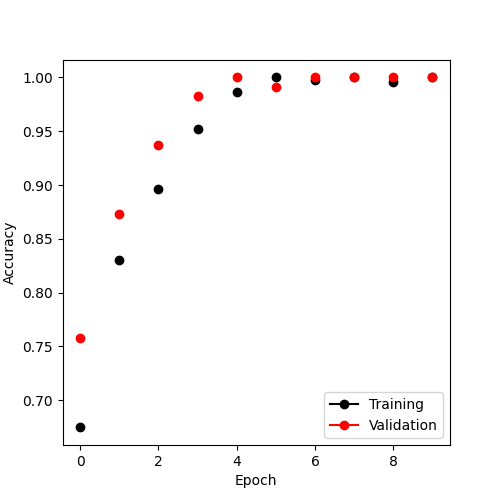

In [29]:
torusLink_results = pd.read_csv(torusLink_logger.experiment.metrics_file_path)
fig, ax = pyplot.subplots(1, 1, figsize=(5, 5))
summary_plot(torusLink_results, ax, 'accuracy', 'Accuracy')

### Cleanup 

In [30]:
del(torusLink_model, torusLink_dm, torusLink_module,
    torusLink_logger,torusLink_trainer,
    features_tmp, responses_tmp)
plt.close()

## Network complexity

We want to use the number of parameters in a neural network as a measure of its complexity. We restrict ourselves to the networks in which all the layers have the same size. We typically write $s$ for this size, and $l$ for the number of layers. The number of parameters in a neural network with $l$ layers, each of size $s$ is 
$$
p(l, s) = (l-1)s^2 + (l+n-3)s + n.
$$
(This holds in our special case of imput dimension $3$ and $n$ output layers.) In more generality, for a neural network whose hidden layers have sizes recorded in an array `layer_sizes`, the total number of parameters can be recovered using the function below. 

In [31]:
def num_parameters(layer_sizes, input_size, output_size):
    if output_size == 2:
        output_size_ = 1
    else:
        output_size_ = output_size
        
    num_param = (input_size + 1)*layer_sizes[0]
    for i in range(len(layer_sizes) - 1):
        num_param += (layer_sizes[i] + 1)*layer_sizes[i + 1]
    num_param += (layer_sizes[-1] + 1)*output_size_
    return num_param
#num_parameters(layer_sizes, 3, n)

We write a function that provides the pairs $(l, s)$ for which the networks with $l$ layers, all of size $s$ have a target number $P$ of parameters, i.e, the $(l, s)$ for which $p(l, s) = P$. 

In [32]:
def possibleLayerLayouts(P, n):
    if n == 2:
        n_ = 1
    else: 
        n_ = n
        
    if P <= n_: 
        return []
    possible_pairs = []
    s_max = max(n_ + 1, (2 - n_ + np.sqrt((n_-2)**2 + 4*(P-n_)))/2)
    for s in range(1, int(s_max) + 1):
        l = (P - n_ - (n_+4)*s)/(s + s**2) + 1
        if l.is_integer(): 
            if l > 0:
                possible_pairs.append([int(l), s])
    return possible_pairs

In [33]:
#Testing the function above
P = 38
n = 2
possibleLayerLayouts(P, n), [num_parameters(layer_layout[1]*np.ones(layer_layout[0]), 3, n) for layer_layout in possibleLayerLayouts(P, n)]

([[17, 1]], [38.0])

Because we shall use these values many times in what follows, we generate an array whose $P$-th entry is an array consisting of all the pairs $(l, s)$ for which $p(l, s)$ equals $P$. This avoids recomputing the same numbers many times over. 

In [34]:
def architectures(P_max, n):
    architectures = []
    for P in range(1, P_max + 1):
        architectures.append(possibleLayerLayouts(P, n))
    return architectures

## The experiment

### Two strands

The setup is complete. We measure the number of parameters a neural network needs to have in order to separate --with an accuracy of at $95\%$-- the three strands of a $(2p, 2)$-torus link for $p > 0$. We store the results in array `measured_min_parameters`. Using the `architectures()` function above, we iterate over the possible network architectures, ordered by number of parameters. 

Before launching an automated computation, we verify a few cases by hand and confirm three predictable facts: 
- the function that maps $p$ to the minimum number of parameters a neural network needs to have to successfully separate the strands of a $(np, p)$-torus links is (very) increasing,
- the neural networks with $l$ layers, all of size $s$ with $l>s$ tend to perform very poorly for this task.
- the neural networks with layers of size $s$ with $s<n$ also perform very poorly. 

Thus we can modify the code in the cells above for the computation of the subsequent values:
- when trying to separate the strands of a certain link, we do not have to give the architectures that failed separating the strands of a less tangled link a try,
- we do not have to give the architectures with $l>s$ a try.
- we do not have to give the architectures with $s<n$ a try.
  
This could slightly speed up the process. We edit the code above accordingly and produce new functions `admissibleLayerLayouts`, `admissibleArchitectures` below. 

In [243]:
def admissibleLayerLayouts(P, n):
    if n == 2:
        n_ = 1
    else: 
        n_ = n
        
    if P <= n_: 
        return []
    possible_pairs = []
    s_max = max(n_ + 1, (2 - n_ + np.sqrt((n_-2)**2 + 4*(P-n_)))/2)
    for s in range(n_, int(s_max) + 1):
        l = (P - n_ - (n_+4)*s)/(s + s**2) + 1
        if l.is_integer(): 
            if l > 0 and s > l:
                possible_pairs.append([int(l), s])
    return possible_pairs

In [244]:
def admissibleArchitectures(P_max, n):
    architectures = []
    for P in range(1, P_max + 1):
        architectures.append(admissibleLayerLayouts(P, n))
    return architectures

In [249]:
def min_parameters(p, q, admissible_architectures): 
    n = int(np.gcd(p, q))
    
    N = 10000
    N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
    M = n*int(N/(10*n)) #A smaller size for validation and test
    
    max_num_workers = rec_num_workers()

    i = 0
    
    while i < len(admissible_architectures): 
        for layer_layout in admissible_architectures[i]: 
            layer_sizes = (layer_layout[1]*np.ones(layer_layout[0])).astype(int)
            num_param = num_parameters(layer_sizes, 3, n)
            print("Trying a network with architecture", layer_sizes, "--", num_param, "parameters.")
            features_tmp, responses_tmp = simulateData(p, q, N)
            torusLinkFeatures_train_t = torch.tensor(features_tmp.astype(np.float32))
            if n == 2:
                torusLinkResponses_train_t = torch.tensor(responses_tmp.astype(np.float32))
            else: 
                torusLinkResponses_train_t = torch.tensor(responses_tmp.astype(np.int64))
            torusLinkData_train = TensorDataset(torusLinkFeatures_train_t, torusLinkResponses_train_t)
            
            features_tmp, responses_tmp = simulateData(p, q, M)
            torusLinkFeatures_val_t = torch.tensor(features_tmp.astype(np.float32))
            if n == 2:
                torusLinkResponses_val_t = torch.tensor(responses_tmp.astype(np.float32))
            else: 
                torusLinkResponses_val_t = torch.tensor(responses_tmp.astype(np.int64))
            torusLinkData_val = TensorDataset(torusLinkFeatures_val_t, torusLinkResponses_val_t)
            
            features_tmp, responses_tmp = simulateData(p, q, M)
            torusLinkFeatures_test_t = torch.tensor(features_tmp.astype(np.float32))
            if n == 2:
                torusLinkResponses_test_t = torch.tensor(responses_tmp.astype(np.float32))
            else:
                torusLinkResponses_test_t = torch.tensor(responses_tmp.astype(np.int64))
            torusLinkData_test = TensorDataset(torusLinkFeatures_test_t, torusLinkResponses_test_t)

            torusLink_dm = SimpleDataModule(torusLinkData_train,
                                  torusLinkData_test,
                                  batch_size = 32,
                                  num_workers = max_num_workers,
                                  validation = torusLinkData_val)

            torusLink_model = TorusLinkModel(layer_sizes, 3, n)
            if n == 2:
                torusLink_module = SimpleModule.binary_classification(torusLink_model)
            elif n > 2:
                torusLink_module = SimpleModule.classification(torusLink_model, num_classes = n)

            torusLink_logger = CSVLogger('logs', name = 'torusLink')

            torusLink_trainer = Trainer(deterministic = False,
                              max_epochs = 50,
                              log_every_n_steps = 5,
                              logger = torusLink_logger,
                              callbacks = [ErrorTracker(), EarlyStopping(monitor = 'valid_accuracy', patience = 4, mode = 'max', min_delta = 0.01, verbose = True)])
            torusLink_trainer.fit(torusLink_module, datamodule = torusLink_dm)
            
            torusLink_results = pd.read_csv(torusLink_logger.experiment.metrics_file_path)
            accuracy = torusLink_results['valid_accuracy'].dropna().iloc[-1] 

            
            print(accuracy)
            
            if accuracy > 0.95: 
                return num_param
        admissible_architectures.pop(0)
    return -1

In [250]:
measured_min_parameters = []
admissible_architectures = admissibleArchitectures(1000, n)
for p in range(1, 9):
    print("Trying to separate the two strands of a (" + str(2*p) + ", " + str(2) + ")-torus link.")
    measured_min_parameters.append(min_parameters(2*p, 2, admissible_architectures))
measured_min_parameters #[16, 41, 92, 136, 226, 430, 897, 1765]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 11     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
11        Trainable params
0         Non-trainable params
11        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Trying to separate the three strands of a (2, 2)-torus link.
Trying a network with architecture [2] -- 11 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.715


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.748


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.748. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 16     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.7490000128746033
Trying a network with architecture [3] -- 16 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.974


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.991


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.991. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 16     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.9980000257492064
Trying to separate the three strands of a (4, 2)-torus link.
Trying a network with architecture [3] -- 16 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.699


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.699. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 21     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.625
Trying a network with architecture [4] -- 21 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.742


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.020 >= min_delta = 0.01. New best score: 0.762


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.781


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.024 >= min_delta = 0.01. New best score: 0.805


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.821


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.832


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.832. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 26     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
26        Trainable params
0         Non-trainable params
26        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.8320000171661377
Trying a network with architecture [5] -- 26 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.860


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.890


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.901


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.901. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 28     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
28        Trainable params
0         Non-trainable params
28        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.9039999842643738
Trying a network with architecture [3 3] -- 28 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.794


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.822


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.840


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.840. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 31     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
31        Trainable params
0         Non-trainable params
31        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.7889999747276306
Trying a network with architecture [6] -- 31 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.657


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.193 >= min_delta = 0.01. New best score: 0.850


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.869


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.01. New best score: 0.894


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.894. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 41     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
41        Trainable params
0         Non-trainable params
41        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.8899999856948853
Trying a network with architecture [4 4] -- 41 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.886


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.902


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.930


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.943


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.969


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.983


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.983. Signaling Trainer to stop.


0.9829999804496764
Trying to separate the three strands of a (6, 2)-torus link.
Trying a network with architecture [4 4] -- 41 parameters.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 41     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
41        Trainable params
0         Non-trainable params
41        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.632


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.098 >= min_delta = 0.01. New best score: 0.730


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.034 >= min_delta = 0.01. New best score: 0.764


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.01. New best score: 0.808


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.035 >= min_delta = 0.01. New best score: 0.843


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.021 >= min_delta = 0.01. New best score: 0.864


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.881


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.881. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 56     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.8640000224113464
Trying a network with architecture [5 5] -- 56 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.706


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.056 >= min_delta = 0.01. New best score: 0.762


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.779


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.790


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.790. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 61     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
61        Trainable params
0         Non-trainable params
61        Total params
0.000     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.746999979019165
Trying a network with architecture [4 4 4] -- 61 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.771


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.123 >= min_delta = 0.01. New best score: 0.894


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.910


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.940


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.940. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 73     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
73        Trainable params
0         Non-trainable params
73        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.9430000185966492
Trying a network with architecture [6 6] -- 73 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.731


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.085 >= min_delta = 0.01. New best score: 0.816


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.022 >= min_delta = 0.01. New best score: 0.838


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.045 >= min_delta = 0.01. New best score: 0.883


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.898


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.916


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.916. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 86     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
86        Trainable params
0         Non-trainable params
86        Total params
0.000     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.9240000247955322
Trying a network with architecture [5 5 5] -- 86 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 92     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
92        Trainable params
0         Non-trainable params
92        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [7 7] -- 92 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.753


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.075 >= min_delta = 0.01. New best score: 0.828


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.070 >= min_delta = 0.01. New best score: 0.898


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.024 >= min_delta = 0.01. New best score: 0.922


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.048 >= min_delta = 0.01. New best score: 0.970


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.987


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.987. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 92     | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
92        Trainable params
0         Non-trainable params
92        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.9919999837875366
Trying to separate the three strands of a (8, 2)-torus link.
Trying a network with architecture [7 7] -- 92 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.627


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.664


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.131 >= min_delta = 0.01. New best score: 0.795


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.036 >= min_delta = 0.01. New best score: 0.831


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.831. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 113    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
113       Trainable params
0         Non-trainable params
113       Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.8259999752044678
Trying a network with architecture [8 8] -- 113 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.695


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.101 >= min_delta = 0.01. New best score: 0.796


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.01. New best score: 0.821


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.024 >= min_delta = 0.01. New best score: 0.845


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.063 >= min_delta = 0.01. New best score: 0.908


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.924


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.031 >= min_delta = 0.01. New best score: 0.955


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.955. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 115    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
115       Trainable params
0         Non-trainable params
115       Total params
0.000     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.949999988079071
Trying a network with architecture [6 6 6] -- 115 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.686


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.041 >= min_delta = 0.01. New best score: 0.727


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.757


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.771


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.785


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.798


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.798. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 116    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
116       Trainable params
0         Non-trainable params
116       Total params
0.000     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.7929999828338623
Trying a network with architecture [5 5 5 5] -- 116 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 136    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
136       Trainable params
0         Non-trainable params
136       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [9 9] -- 136 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.660


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.136 >= min_delta = 0.01. New best score: 0.796


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.035 >= min_delta = 0.01. New best score: 0.831


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.064 >= min_delta = 0.01. New best score: 0.895


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.078 >= min_delta = 0.01. New best score: 0.973


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.973. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 136    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
136       Trainable params
0         Non-trainable params
136       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.9660000205039978
Trying to separate the three strands of a (10, 2)-torus link.
Trying a network with architecture [9 9] -- 136 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.504


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.107 >= min_delta = 0.01. New best score: 0.611


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.084 >= min_delta = 0.01. New best score: 0.695


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.706


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.725


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.062 >= min_delta = 0.01. New best score: 0.787


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.053 >= min_delta = 0.01. New best score: 0.840


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.840. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 148    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
148       Trainable params
0         Non-trainable params
148       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.7919999957084656
Trying a network with architecture [7 7 7] -- 148 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.621


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.064 >= min_delta = 0.01. New best score: 0.685


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.055 >= min_delta = 0.01. New best score: 0.740


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.052 >= min_delta = 0.01. New best score: 0.792


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.040 >= min_delta = 0.01. New best score: 0.832


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.081 >= min_delta = 0.01. New best score: 0.913


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.913. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 157    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.9089999794960022
Trying a network with architecture [6 6 6 6] -- 157 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 161    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
161       Trainable params
0         Non-trainable params
161       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [10 10] -- 161 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.551


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.049 >= min_delta = 0.01. New best score: 0.600


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.630


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.087 >= min_delta = 0.01. New best score: 0.717


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.740


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.021 >= min_delta = 0.01. New best score: 0.761


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.791


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.041 >= min_delta = 0.01. New best score: 0.832


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.846


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.862


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.876


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.021 >= min_delta = 0.01. New best score: 0.897


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.897. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 185    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
185       Trainable params
0         Non-trainable params
185       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.8289999961853027
Trying a network with architecture [8 8 8] -- 185 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 188    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
188       Trainable params
0         Non-trainable params
188       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [11 11] -- 188 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.584


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.104 >= min_delta = 0.01. New best score: 0.688


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.080 >= min_delta = 0.01. New best score: 0.768


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.796


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.042 >= min_delta = 0.01. New best score: 0.838


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.851


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.879


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.022 >= min_delta = 0.01. New best score: 0.901


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.901. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 199    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
199       Trainable params
0         Non-trainable params
199       Total params
0.001     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.8920000195503235
Trying a network with architecture [6 6 6 6 6] -- 199 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.569


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.040 >= min_delta = 0.01. New best score: 0.609


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.627


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.643


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.643. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 204    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.640999972820282
Trying a network with architecture [7 7 7 7] -- 204 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.544


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.077 >= min_delta = 0.01. New best score: 0.621


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.636


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.636. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 217    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.628000020980835
Trying a network with architecture [12 12] -- 217 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.512


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.120 >= min_delta = 0.01. New best score: 0.632


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.154 >= min_delta = 0.01. New best score: 0.786


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.816


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.855


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.906


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.906. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 226    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.9070000052452089
Trying a network with architecture [9 9 9] -- 226 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.609


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.159 >= min_delta = 0.01. New best score: 0.768


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.113 >= min_delta = 0.01. New best score: 0.881


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.908


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.923


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.946


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.961


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.961. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 226    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.9559999704360962
Trying to separate the three strands of a (12, 2)-torus link.
Trying a network with architecture [9 9 9] -- 226 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.119 >= min_delta = 0.01. New best score: 0.619


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.097 >= min_delta = 0.01. New best score: 0.716


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.065 >= min_delta = 0.01. New best score: 0.781


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.832


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.847


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.847. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 248    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
248       Trainable params
0         Non-trainable params
248       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.8259999752044678
Trying a network with architecture [13 13] -- 248 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.532


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.029 >= min_delta = 0.01. New best score: 0.561


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.576


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.068 >= min_delta = 0.01. New best score: 0.644


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.663


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.021 >= min_delta = 0.01. New best score: 0.684


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.699


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.742


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.742. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 257    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
257       Trainable params
0         Non-trainable params
257       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.7360000014305115
Trying a network with architecture [8 8 8 8] -- 257 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.567


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.610


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.066 >= min_delta = 0.01. New best score: 0.676


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.699


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.725


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.059 >= min_delta = 0.01. New best score: 0.784


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.812


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.812. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 260    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
260       Trainable params
0         Non-trainable params
260       Total params
0.001     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.8059999942779541
Trying a network with architecture [7 7 7 7 7] -- 260 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 271    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
271       Trainable params
0         Non-trainable params
271       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [10 10 10] -- 271 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 281    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
281       Trainable params
0         Non-trainable params
281       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [14 14] -- 281 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.505


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.544


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.558


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.041 >= min_delta = 0.01. New best score: 0.599


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.047 >= min_delta = 0.01. New best score: 0.646


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.661


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.029 >= min_delta = 0.01. New best score: 0.690


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.031 >= min_delta = 0.01. New best score: 0.721


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.749


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.749. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 316    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
316       Trainable params
0         Non-trainable params
316       Total params
0.001     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.7139999866485596
Trying a network with architecture [7 7 7 7 7 7] -- 316 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 316    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
316       Trainable params
0         Non-trainable params
316       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [9 9 9 9] -- 316 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 316    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
316       Trainable params
0         Non-trainable params
316       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [15 15] -- 316 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.551


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.067 >= min_delta = 0.01. New best score: 0.618


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.055 >= min_delta = 0.01. New best score: 0.673


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.706


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.048 >= min_delta = 0.01. New best score: 0.754


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.059 >= min_delta = 0.01. New best score: 0.813


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.846


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.860


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.860. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 320    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
320       Trainable params
0         Non-trainable params
320       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.8050000071525574
Trying a network with architecture [11 11 11] -- 320 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 329    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
329       Trainable params
0         Non-trainable params
329       Total params
0.001     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [8 8 8 8 8] -- 329 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 353    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
353       Trainable params
0         Non-trainable params
353       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [16 16] -- 353 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.498


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.515


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.080 >= min_delta = 0.01. New best score: 0.595


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.074 >= min_delta = 0.01. New best score: 0.669


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.696


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.739


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.031 >= min_delta = 0.01. New best score: 0.770


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.031 >= min_delta = 0.01. New best score: 0.801


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.819


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.846


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.863


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.874


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.874. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 373    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
373       Trainable params
0         Non-trainable params
373       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.8659999966621399
Trying a network with architecture [12 12 12] -- 373 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.085 >= min_delta = 0.01. New best score: 0.585


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.118 >= min_delta = 0.01. New best score: 0.703


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.052 >= min_delta = 0.01. New best score: 0.755


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.052 >= min_delta = 0.01. New best score: 0.807


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.819


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.856


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.856. Signaling Trainer to stop.


0.8180000185966492
Trying a network with architecture [10 10 10 10] -- 381 parameters.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 381    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
381       Trainable params
0         Non-trainable params
381       Total params
0.002     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.501


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.091 >= min_delta = 0.01. New best score: 0.592


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.098 >= min_delta = 0.01. New best score: 0.690


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.741


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.065 >= min_delta = 0.01. New best score: 0.806


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.825


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.825. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 392    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
392       Trainable params
0         Non-trainable params
392       Total params
0.002     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.8220000267028809
Trying a network with architecture [17 17] -- 392 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.505


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.519


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.061 >= min_delta = 0.01. New best score: 0.580


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.100 >= min_delta = 0.01. New best score: 0.680


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.046 >= min_delta = 0.01. New best score: 0.726


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.737


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.763


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.763. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 401    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
401       Trainable params
0         Non-trainable params
401       Total params
0.002     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.7609999775886536
Trying a network with architecture [8 8 8 8 8 8] -- 401 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 406    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
406       Trainable params
0         Non-trainable params
406       Total params
0.002     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [9 9 9 9 9] -- 406 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 430    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
430       Trainable params
0         Non-trainable params
430       Total params
0.002     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [13 13 13] -- 430 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.499


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.157 >= min_delta = 0.01. New best score: 0.656


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.134 >= min_delta = 0.01. New best score: 0.790


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.035 >= min_delta = 0.01. New best score: 0.825


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.858


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.895


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.934


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.962


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.962. Signaling Trainer to stop.


0.972000002861023


[16, 41, 92, 136, 226, 430]

In [262]:
admissible_architectures = admissibleArchitectures(5000, n)
admissible_architectures = admissible_architectures[2200:]
measured_min_parameters = [16, 41, 92, 136, 226, 430]
for p in range(9, 11):
    print("Trying to separate the two strands of a (" + str(2*p) + ", " + str(2) + ")-torus link.")
    measured_min_parameters.append(min_parameters(2*p, 2, admissible_architectures))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 401    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
401       Trainable params
0         Non-trainable params
401       Total params
0.002     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Trying to separate the two strands of a (14, 2)-torus link.
Trying a network with architecture [8 8 8 8 8 8] -- 401 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 406    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
406       Trainable params
0         Non-trainable params
406       Total params
0.002     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [9 9 9 9 9] -- 406 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 430    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
430       Trainable params
0         Non-trainable params
430       Total params
0.002     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [13 13 13] -- 430 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 433    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [18 18] -- 433 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.507


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.533


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.031 >= min_delta = 0.01. New best score: 0.564


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.045 >= min_delta = 0.01. New best score: 0.609


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.050 >= min_delta = 0.01. New best score: 0.659


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.01. New best score: 0.697


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.725


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.748


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.774


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.774. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 452    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
452       Trainable params
0         Non-trainable params
452       Total params
0.002     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.7820000052452087
Trying a network with architecture [11 11 11 11] -- 452 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 473    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
473       Trainable params
0         Non-trainable params
473       Total params
0.002     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [8 8 8 8 8 8 8] -- 473 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 476    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
476       Trainable params
0         Non-trainable params
476       Total params
0.002     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [19 19] -- 476 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.022 >= min_delta = 0.01. New best score: 0.522


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.040 >= min_delta = 0.01. New best score: 0.562


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.573


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.050 >= min_delta = 0.01. New best score: 0.623


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.062 >= min_delta = 0.01. New best score: 0.685


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.045 >= min_delta = 0.01. New best score: 0.730


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.743


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.055 >= min_delta = 0.01. New best score: 0.798


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.01. New best score: 0.808


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.847


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.01. New best score: 0.872


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.872. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 491    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.828000009059906
Trying a network with architecture [10 10 10 10 10] -- 491 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 491    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [14 14 14] -- 491 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 496    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
496       Trainable params
0         Non-trainable params
496       Total params
0.002     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [9 9 9 9 9 9] -- 496 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 521    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
521       Trainable params
0         Non-trainable params
521       Total params
0.002     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [20 20] -- 521 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.020 >= min_delta = 0.01. New best score: 0.520


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.105 >= min_delta = 0.01. New best score: 0.625


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.01. New best score: 0.669


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.680


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.081 >= min_delta = 0.01. New best score: 0.761


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.787


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.801


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.827


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.827. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 529    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.824999988079071
Trying a network with architecture [12 12 12 12] -- 529 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 556    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
556       Trainable params
0         Non-trainable params
556       Total params
0.002     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [15 15 15] -- 556 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.055 >= min_delta = 0.01. New best score: 0.555


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.081 >= min_delta = 0.01. New best score: 0.636


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.01. New best score: 0.674


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.690


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.024 >= min_delta = 0.01. New best score: 0.714


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.757


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.770


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.788


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.022 >= min_delta = 0.01. New best score: 0.810


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.828


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.828. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 568    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
568       Trainable params
0         Non-trainable params
568       Total params
0.002     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.7749999761581421
Trying a network with architecture [21 21] -- 568 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.504


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.531


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.077 >= min_delta = 0.01. New best score: 0.608


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.073 >= min_delta = 0.01. New best score: 0.681


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.049 >= min_delta = 0.01. New best score: 0.730


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.029 >= min_delta = 0.01. New best score: 0.759


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.036 >= min_delta = 0.01. New best score: 0.795


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.832


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.845


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.845. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 584    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
584       Trainable params
0         Non-trainable params
584       Total params
0.002     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.8399999737739563
Trying a network with architecture [11 11 11 11 11] -- 584 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 586    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
586       Trainable params
0         Non-trainable params
586       Total params
0.002     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [9 9 9 9 9 9 9] -- 586 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 601    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
601       Trainable params
0         Non-trainable params
601       Total params
0.002     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [10 10 10 10 10 10] -- 601 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 612    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
612       Trainable params
0         Non-trainable params
612       Total params
0.002     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [13 13 13 13] -- 612 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 617    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
617       Trainable params
0         Non-trainable params
617       Total params
0.002     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [22 22] -- 617 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.527


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.056 >= min_delta = 0.01. New best score: 0.583


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.060 >= min_delta = 0.01. New best score: 0.643


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.036 >= min_delta = 0.01. New best score: 0.679


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.01. New best score: 0.717


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.052 >= min_delta = 0.01. New best score: 0.769


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.806


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.822


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.833


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.020 >= min_delta = 0.01. New best score: 0.853


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.853. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 625    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
625       Trainable params
0         Non-trainable params
625       Total params
0.003     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.8550000190734863
Trying a network with architecture [16 16 16] -- 625 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 668    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
668       Trainable params
0         Non-trainable params
668       Total params
0.003     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [23 23] -- 668 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.514


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.063 >= min_delta = 0.01. New best score: 0.577


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.589


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.047 >= min_delta = 0.01. New best score: 0.636


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.687


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.687. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 676    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
676       Trainable params
0         Non-trainable params
676       Total params
0.003     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


0.6769999861717224
Trying a network with architecture [9 9 9 9 9 9 9 9] -- 676 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 685    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
685       Trainable params
0         Non-trainable params
685       Total params
0.003     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [12 12 12 12 12] -- 685 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.


0.5
Trying a network with architecture [17 17 17] -- 698 parameters.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 698    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
698       Trainable params
0         Non-trainable params
698       Total params
0.003     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 701    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
701       Trainable params
0         Non-trainable params
701       Total params
0.003     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [14 14 14 14] -- 701 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 711    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
711       Trainable params
0         Non-trainable params
711       Total params
0.003     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [10 10 10 10 10 10 10] -- 711 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 716    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
716       Trainable params
0         Non-trainable params
716       Total params
0.003     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [11 11 11 11 11 11] -- 716 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 721    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
721       Trainable params
0         Non-trainable params
721       Total params
0.003     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [24 24] -- 721 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 775    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
775       Trainable params
0         Non-trainable params
775       Total params
0.003     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [18 18 18] -- 775 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.499


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.499. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 776    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
776       Trainable params
0         Non-trainable params
776       Total params
0.003     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [25 25] -- 776 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.528


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.547


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.590


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.049 >= min_delta = 0.01. New best score: 0.639


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.035 >= min_delta = 0.01. New best score: 0.674


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.050 >= min_delta = 0.01. New best score: 0.724


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.761


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.01. New best score: 0.771


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.031 >= min_delta = 0.01. New best score: 0.802


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.815


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.036 >= min_delta = 0.01. New best score: 0.851


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.862


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.875


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.894


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.894. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 794    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
794       Trainable params
0         Non-trainable params
794       Total params
0.003     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.8550000190734863
Trying a network with architecture [13 13 13 13 13] -- 794 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.523


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.063 >= min_delta = 0.01. New best score: 0.586


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.613


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.029 >= min_delta = 0.01. New best score: 0.642


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.084 >= min_delta = 0.01. New best score: 0.726


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.739


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.755


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.01. New best score: 0.780


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.797


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.020 >= min_delta = 0.01. New best score: 0.817


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.817. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 796    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
796       Trainable params
0         Non-trainable params
796       Total params
0.003     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.7549999952316284
Trying a network with architecture [15 15 15 15] -- 796 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 821    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
821       Trainable params
0         Non-trainable params
821       Total params
0.003     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [10 10 10 10 10 10 10 10] -- 821 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 833    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
833       Trainable params
0         Non-trainable params
833       Total params
0.003     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [26 26] -- 833 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.503


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.087 >= min_delta = 0.01. New best score: 0.590


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.103 >= min_delta = 0.01. New best score: 0.693


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.022 >= min_delta = 0.01. New best score: 0.715


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.728


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.022 >= min_delta = 0.01. New best score: 0.750


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.766


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.048 >= min_delta = 0.01. New best score: 0.814


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.024 >= min_delta = 0.01. New best score: 0.838


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.852


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.852. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 841    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
841       Trainable params
0         Non-trainable params
841       Total params
0.003     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.8180000185966492
Trying a network with architecture [12 12 12 12 12 12] -- 841 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 848    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
848       Trainable params
0         Non-trainable params
848       Total params
0.003     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [11 11 11 11 11 11 11] -- 848 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 856    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
856       Trainable params
0         Non-trainable params
856       Total params
0.003     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [19 19 19] -- 856 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 892    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
892       Trainable params
0         Non-trainable params
892       Total params
0.004     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [27 27] -- 892 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.497


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.510


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.091 >= min_delta = 0.01. New best score: 0.601


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.078 >= min_delta = 0.01. New best score: 0.679


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.055 >= min_delta = 0.01. New best score: 0.734


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.746


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.761


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.784


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.799


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.799. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 897    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
897       Trainable params
0         Non-trainable params
897       Total params
0.004     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.7950000166893005
Trying a network with architecture [16 16 16 16] -- 897 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.105 >= min_delta = 0.01. New best score: 0.605


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.635


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.077 >= min_delta = 0.01. New best score: 0.712


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.049 >= min_delta = 0.01. New best score: 0.761


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.073 >= min_delta = 0.01. New best score: 0.834


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.058 >= min_delta = 0.01. New best score: 0.892


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.925


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.01. New best score: 0.950


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.964


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.979


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.979. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 897    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
897       Trainable params
0         Non-trainable params
897       Total params
0.004     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.9860000014305116
Trying to separate the two strands of a (16, 2)-torus link.
Trying a network with architecture [16 16 16 16] -- 897 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 911    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
911       Trainable params
0         Non-trainable params
911       Total params
0.004     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [14 14 14 14 14] -- 911 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 931    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
931       Trainable params
0         Non-trainable params
931       Total params
0.004     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [10 10 10 10 10 10 10 10 10] -- 931 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 941    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
941       Trainable params
0         Non-trainable params
941       Total params
0.004     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [20 20 20] -- 941 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.032 >= min_delta = 0.01. New best score: 0.532


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.047 >= min_delta = 0.01. New best score: 0.579


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.622


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.036 >= min_delta = 0.01. New best score: 0.658


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.709


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.034 >= min_delta = 0.01. New best score: 0.743


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.743. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


0.7409999966621399
Trying a network with architecture [28 28] -- 953 parameters.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 953    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
953       Trainable params
0         Non-trainable params
953       Total params
0.004     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 976    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
976       Trainable params
0         Non-trainable params
976       Total params
0.004     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [13 13 13 13 13 13] -- 976 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 980    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
980       Trainable params
0         Non-trainable params
980       Total params
0.004     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [11 11 11 11 11 11 11 11] -- 980 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 997    | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
997       Trainable params
0         Non-trainable params
997       Total params
0.004     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [12 12 12 12 12 12 12] -- 997 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.


0.5
Trying a network with architecture [17 17 17 17] -- 1004 parameters.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.0 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.0 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [29 29] -- 1016 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.517


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.540


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.032 >= min_delta = 0.01. New best score: 0.572


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.583


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.045 >= min_delta = 0.01. New best score: 0.628


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.679


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.694


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.694. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.0 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.6759999990463257
Trying a network with architecture [21 21 21] -- 1030 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.0 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [15 15 15 15 15] -- 1036 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.1 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [30 30] -- 1081 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.1 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [11 11 11 11 11 11 11 11 11] -- 1112 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.1 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [18 18 18 18] -- 1117 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.1 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [14 14 14 14 14 14] -- 1121 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.1 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [22 22 22] -- 1123 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.501


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.501. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.1 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.005     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [31 31] -- 1148 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.01. New best score: 0.544


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.587


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.630


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.669


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.047 >= min_delta = 0.01. New best score: 0.716


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.729


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.047 >= min_delta = 0.01. New best score: 0.776


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.789


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.042 >= min_delta = 0.01. New best score: 0.831


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.831. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.2 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


0.7889999747276306
Trying a network with architecture [12 12 12 12 12 12 12 12] -- 1153 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.2 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [13 13 13 13 13 13 13] -- 1158 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.2 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [16 16 16 16 16] -- 1169 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.2 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [32 32] -- 1217 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.042 >= min_delta = 0.01. New best score: 0.542


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.059 >= min_delta = 0.01. New best score: 0.601


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.085 >= min_delta = 0.01. New best score: 0.686


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.723


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.738


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.040 >= min_delta = 0.01. New best score: 0.778


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.792


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.810


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.032 >= min_delta = 0.01. New best score: 0.842


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.857


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.871


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.884


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.884. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.2 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.8840000033378601
Trying a network with architecture [23 23 23] -- 1220 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.502


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.502. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.2 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [19 19 19 19] -- 1236 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.2 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [11 11 11 11 11 11 11 11 11 11] -- 1244 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.3 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [15 15 15 15 15 15] -- 1276 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.3 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [33 33] -- 1288 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.3 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [12 12 12 12 12 12 12 12 12] -- 1309 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.3 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [17 17 17 17 17] -- 1310 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.3 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [24 24 24] -- 1321 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.


0.5
Trying a network with architecture [14 14 14 14 14 14 14] -- 1331 parameters.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.3 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.3 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [13 13 13 13 13 13 13 13] -- 1340 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.499


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.499. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.4 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [20 20 20 20] -- 1361 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.539


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.078 >= min_delta = 0.01. New best score: 0.617


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.055 >= min_delta = 0.01. New best score: 0.672


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.715


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.01. New best score: 0.759


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.036 >= min_delta = 0.01. New best score: 0.795


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.823


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.034 >= min_delta = 0.01. New best score: 0.857


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.857. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.4 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.8539999723434448
Trying a network with architecture [34 34] -- 1361 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.4 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [25 25 25] -- 1426 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.4 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [35 35] -- 1436 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.4 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [16 16 16 16 16 16] -- 1441 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.5 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [18 18 18 18 18] -- 1459 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.5 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [12 12 12 12 12 12 12 12 12 12] -- 1465 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.5 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [21 21 21 21] -- 1492 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.5 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [36 36] -- 1513 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.5 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [15 15 15 15 15 15 15] -- 1516 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.5 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [13 13 13 13 13 13 13 13 13] -- 1522 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.5 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [26 26 26] -- 1535 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.5 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [14 14 14 14 14 14 14 14] -- 1541 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.6 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [37 37] -- 1592 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.050 >= min_delta = 0.01. New best score: 0.550


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.569


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.059 >= min_delta = 0.01. New best score: 0.628


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.642


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.057 >= min_delta = 0.01. New best score: 0.699


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.049 >= min_delta = 0.01. New best score: 0.748


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.760


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.772


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.791


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.791. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.6 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.7649999856948853
Trying a network with architecture [17 17 17 17 17 17] -- 1616 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.6 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [19 19 19 19 19] -- 1616 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.6 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
59        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [12 12 12 12 12 12 12 12 12 12 12] -- 1621 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.6 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.007     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [22 22 22 22] -- 1629 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.6 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.007     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [27 27 27] -- 1648 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.7 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [38 38] -- 1673 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.7 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [13 13 13 13 13 13 13 13 13 13] -- 1704 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.7 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [16 16 16 16 16 16 16] -- 1713 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.8 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [14 14 14 14 14 14 14 14 14] -- 1751 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.8 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [15 15 15 15 15 15 15 15] -- 1756 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.8 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [39 39] -- 1756 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.8 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [28 28 28] -- 1765 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.499


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.517


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.103 >= min_delta = 0.01. New best score: 0.620


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.054 >= min_delta = 0.01. New best score: 0.674


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.084 >= min_delta = 0.01. New best score: 0.758


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.785


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.055 >= min_delta = 0.01. New best score: 0.840


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.856


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.868


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.01. New best score: 0.912


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.927


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.939


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.01. New best score: 0.964


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.978


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.989


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.989. Signaling Trainer to stop.


0.9929999709129332
Trying to separate the two strands of a (18, 2)-torus link.
Trying a network with architecture [28 28 28] -- 1765 parameters.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.8 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.8 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [23 23 23 23] -- 1772 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.499


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.499. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.8 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [20 20 20 20 20] -- 1781 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.8 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [18 18 18 18 18 18] -- 1801 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.8 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [40 40] -- 1841 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 4 records. Best score: 0.500. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TorusLinkModel    | 1.9 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
59        Modules in train mode
0         Modules in eval mode


0.5
Trying a network with architecture [13 13 13 13 13 13 13 13 13 13 13] -- 1886 parameters.


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.500


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

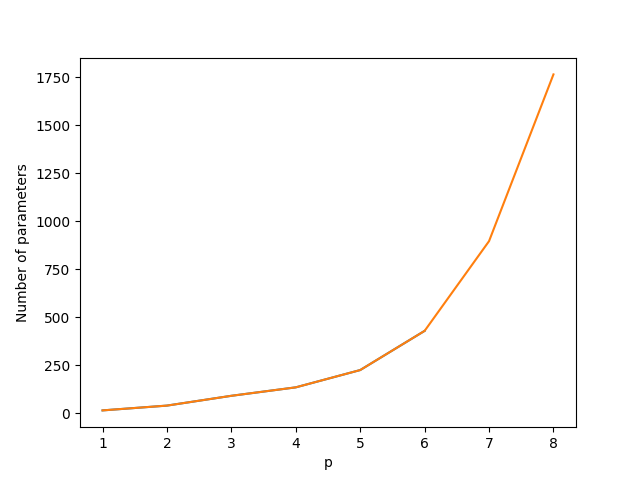

In [263]:
plt.plot(range(1, len(measured_min_parameters) + 1), measured_min_parameters)
plt.ylabel('Number of parameters')
plt.xlabel('p')
plt.show()

In [265]:
del(torusLink_model, torusLink_dm, torusLink_module,
    torusLink_logger,torusLink_trainer,
    features_tmp, responses_tmp)
plt.close()

NameError: name 'torusLink_model' is not defined

### Three strands

We measure the number of parameters a neural network needs to have in order to separate --with an accuracy of at $95\%$-- the three strands of a $(3p, 3)$-torus link for $p > 0$. We store the results in array `measured_min_parameters`. We use an identical setup. 

In [ ]:
measured_min_parameters = []
admissible_architectures = admissibleArchitectures(1000, n)
for p in range(1, 7):
    print("Trying to separate the three strands of a (" + str(3*p) + ", " + str(3) + ")-torus link.")
    measured_min_parameters.append(min_parameters(3*p, 3, admissible_architectures))
measured_min_parameters #[38, 108, 183, 399, 983, 1823]

In [ ]:
admissible_architectures = admissibleArchitectures(5000, n)
admissible_architectures = admissible_architectures[600:]
measured_min_parameters = [38, 108, 183, 399, 983, 1823]
for p in range(7, 10):
    print("Trying to separate the three strands of a (" + str(3*p) + ", " + str(3) + ")-torus link.")
    measured_min_parameters.append(min_parameters(3*p, 3, admissible_architectures))

## Conclusions

The relationship is seen to be exponential, which seems to suggest that in general, the more intricate the problem, the exponentially more complex a neural network needs to be in order to succeed in tackling it. Our experiment was conducted using classification problems in which the data was exactly placed along (low-dimensional) embedded submanifold of the ambient input space, which makes us formulate the following caveat: even if the manifold hypothesis holds true (https://en.wikipedia.org/wiki/Manifold_hypothesis), there could be situations of high tangledness in which embedded submanifolds can get arbitrarily hard to distinguish. 